<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>

* [0. OBJECTIVES and SCOPE](#0)
* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING DATA](#2)    
* [3. DATA PIPELINE](#3) (Maleable section)
* [4. EXPLORATORY DATA ANALYSIS](#4)     
* [5. MODELING](#5)
* [6. EVALUATION](#6)
* [7. DISCUSSION](#7)  
* [8. DEPLOYMENT AND ENSEMBLES](#8)
* [9. END](#9)

<a id="0"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">OBJECTIVES and SCOPE</p>

<span style="color:green">Questions</span><br><br>
Before performing EDA, we should have a clear objective. So we can make the right questions and the right visualizations.<br>
* Q1: What types of video titles and thumbnails drive the most traffic?
* Q2: What type of content are people engaging with the most or watching the longest? (avg watch time and avg view percentage)
* Q3: What is the SEO applied and what it's the performance?
* Q4: Who is the core audience and what are they interested in?
* Q5: What types of videos have lead to the most growth and bad growth (subs removed)? 
* Q6: When the retention peaks happen? what did the youtuber for that peaks? (Important question for SEO-Frame techniques)
* Q7: What are the keywords used? These answer to search intents?
* Q8: What are the SEO techniques applied? Which give the best results?
* Q9: What are the top positive/negative words/sentences in comments?
* Q10: What videos produces more relative likes?
* Q11: What videos produces more relative dislikes?
* Q12: What videos produces more relative comments added?
* Q13: What videos generates more social value? (shares)
* Q14: What are the topics of the most liked comments? (clusters)

<br><br>
<span style="color:green">Objectives</span><br>
1) Increase video CTR.<br>
- Related questions: Q1,Q3,Q4,Q5,Q6,Q7,Q8
2) Increase Subscription Ratio.
- Related questions: Q2,Q4,Q5,Q7,Q13.
3) Increase average watch time and get plain retention [good average view %]. (We need more data from youtube studio, specifically relative retention by video) <br>
- Related questions: Q2!,Q6.
4) Find suggestions.
- Related questions: Q5, Q9, Q10, Q11, Q14.
5) Increase interaction:
- Related questions: Q3, Q12, Q13.
6) Extend the total youtube session time. (Note: this is probably the most important objective. The youtube DL algorithm rewards a lot increasing the total session time of a user).
- Related questions: Q2!,Q6!,Q8.

<br>
Not covered (yet):
* Increase revenue: increase RPM and improve CPM.
- Related questions: Q2,Q6!

X) Others:
- Chatbot for address videos.
- Pulling sentiment from thumbnails and titles and comparing that with performance.
- Recommendation system for increase session time. (Chain interlinking)


<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

In [1]:
# Environment variables
path_root = "/home/magody/programming/python/data_science/"
path_data = f"{path_root}data/kenjee_youtube/"
path_output = f"{path_root}output/"

In [26]:
# own libraries
import sys
sys.path.append(f"{path_root}lib")

from insight import * # type: ignore
from utils_math import * # type: ignore
from utils_pandas import * # type: ignore

# ORIGINAL CODE: https://www.kaggle.com/ashbellett/data-engineering/notebook
# Thanks ASH BELLETT for the data cleaning code provided for this part
# I modified the original code a little
sys.path.append(f"{path_root}projects/business/youtube")
from format import *
 

In [5]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from textwrap import wrap

from PIL import Image
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering # lets get crazy XD

<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

## Description
1) Aggregated Metrics By Video - This has all the topline metrics from thre channel from its start (around 2015 to Jan 22 2022).
2) Aggregated Metrics By Video with Country and Subscriber Status - This has the same data as aggregated metrics by video, but it includes dimensions for which country people are viewing from and if the viewers are subscribed to the channel or not.
3) Video Performance Over Time - This has the daily data from each of my videos.
4) All Comments - This is all of the comment data gathered from the YouTube API.

## Load

In [44]:
#Loading the dataset
data1_agg_country_suscriber: pd.DataFrame = pd.read_csv(f"{path_data}Aggregated_Metrics_By_Country_And_Subscriber_Status.csv")
data2_agg_video: pd.DataFrame = pd.read_csv(f"{path_data}Aggregated_Metrics_By_Video.csv")
data3_comments: pd.DataFrame = pd.read_csv(f"{path_data}All_Comments_Final.csv")
data4_video_performance: pd.DataFrame = pd.read_csv(f"{path_data}Video_Performance_Over_Time.csv")

for column in data1_agg_country_suscriber.columns:
    data1_agg_country_suscriber[column] = typecast_column(
        data1_agg_country_suscriber[column],
        PERFORMANCE_SCHEMA_COUNTRY[column]["data_type"]
    )

for column in data2_agg_video.columns:
    data2_agg_video[column] = typecast_column(
        data2_agg_video[column],
        METRICS_SCHEMA[column]["data_type"]
    )
    
for column in data3_comments.columns:
    data3_comments[column] = typecast_column(
        data3_comments[column],
        COMMENTS_SCHEMA[column]["data_type"]
    )
    
for column in data4_video_performance.columns:
    data4_video_performance[column] = typecast_column(
        data4_video_performance[column],
        PERFORMANCE_SCHEMA[column]["data_type"]
    )

data1_agg_country_suscriber.rename(columns=performance_country_column_map, inplace=True)
data2_agg_video.rename(columns=metrics_column_map, inplace=True)
data3_comments.rename(columns=comments_column_map, inplace=True)
data4_video_performance.rename(columns=performance_column_map, inplace=True)


## Eager explotarion

In [30]:
data1_agg_country_suscriber.info()
data1_agg_country_suscriber.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55292 entries, 0 to 55291
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               55292 non-null  object 
 1   video_id            55292 non-null  object 
 2   length              55292 non-null  int16  
 3   thumbnail           55292 non-null  object 
 4   country             55292 non-null  object 
 5   is_subscribed       55292 non-null  bool   
 6   view_count          55292 non-null  int16  
 7   likes_added         55292 non-null  int16  
 8   dislikes_added      55292 non-null  int16  
 9   likes_removed       55292 non-null  int16  
 10  subscribers_gained  55292 non-null  int16  
 11  subscribers_lost    55292 non-null  int16  
 12  average_view_ratio  53854 non-null  float16
 13  average_watch_time  53854 non-null  float16
 14  comments_added      55292 non-null  int16  
dtypes: bool(1), float16(2), int16(8), object(4)
memory us

,title,video_id,length,thumbnail,country,is_subscribed,view_count,likes_added,dislikes_added,likes_removed,subscribers_gained,subscribers_lost,average_view_ratio,average_watch_time,comments_added
0,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,HK,True,23,1,0,0,2,0,0.671875,39.62500,0
1,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,ME,True,3,0,0,0,0,0,0.498779,29.43750,0
2,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,RW,True,2,0,0,0,0,0,0.681641,40.21875,0
3,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,US,True,979,81,6,8,16,4,0.694824,41.00000,0
4,🌶 Hot Topics in Tech: Data Science Explained #...,OtqQYqRNDGI,59,https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg,DE,False,75,3,0,1,0,0,0.661621,39.03125,0


In [23]:
data2_agg_video.info()
data2_agg_video.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Video                                 224 non-null    object        
 1   Video title                           224 non-null    object        
 2   Video pub­lish time                   223 non-null    datetime64[ns]
 3   Com­ments ad­ded                      224 non-null    int16         
 4   Shares                                224 non-null    int16         
 5   Dis­likes                             224 non-null    int16         
 6   Likes                                 224 non-null    int16         
 7   Sub­scribers lost                     224 non-null    int16         
 8   Sub­scribers gained                   224 non-null    int16         
 9   RPM (USD)                             224 non-null    float16       
 10  CP

,Video,Video title,Video pub­lish time,Com­ments ad­ded,Shares,Dis­likes,Likes,Sub­scribers lost,Sub­scribers gained,RPM (USD),CPM (USD),Av­er­age per­cent­age viewed (%),Av­er­age view dur­a­tion,Views,Watch time (hours),Sub­scribers,Your es­tim­ated rev­en­ue (USD),Im­pres­sions,Im­pres­sions click-through rate (%)
0,Total,nan,NaT,14197,-25896,3902,28413,-19746,32633,5.277344,11.992188,26.609375,205,-2073,inf,-13157,29072.000000,28624,3.160156
1,4OZip0cgOho,How I Would Learn Data Science (If I Had to St...,2020-05-08,907,9583,942,-18633,451,-18632,6.351562,12.835938,36.656250,189,8375,inf,-19083,7960.000000,22255,3.140625
2,78LjdAAw0wA,100K Channel Update + AMA Stream!,2020-11-12,412,4,4,130,15,12,2.667969,6.257812,6.261719,314,2291,200.25,-3,6.113281,-8290,0.720215
3,hO_YKK_0Qck,Uber Driver to Machine Learning Engineer in 9 ...,2020-07-16,402,152,15,881,9,198,9.515625,11.695312,15.117188,621,21350,3688.00,189,203.000000,-16418,2.529297
4,uXLnbdHMf8w,Why I'm Starting Data Science Over Again.,2020-08-29,375,367,22,2622,40,1957,3.142578,7.941406,33.406250,156,-15972,2148.00,1917,155.750000,-3103,4.011719


In [24]:
data3_comments.info()
data3_comments.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   Comments     10240 non-null  object             
 1   Comment_ID   10240 non-null  object             
 2   Reply_Count  10240 non-null  int16              
 3   Like_Count   10240 non-null  int16              
 4   Date         10240 non-null  datetime64[ns, UTC]
 5   VidId        10240 non-null  object             
 6   user_ID      10240 non-null  object             
dtypes: datetime64[ns, UTC](1), int16(2), object(4)
memory usage: 440.1+ KB


,Comments,Comment_ID,Reply_Count,Like_Count,Date,VidId,user_ID
0,Thanks for this video Ken.\n\nI decided to go ...,UgxFZTIzC4UPyhhX_PZ4AaABAg,0,0,2022-01-22 08:13:29+00:00,xpIFS6jZbe8,user_981
1,Hello ken jee!!! I'm doing a graduation on Com...,Ugx3IYuAufhb932GYQx4AaABAg,0,0,2022-01-22 01:09:46+00:00,xpIFS6jZbe8,user_213
2,"Thanks for this video, man. So useful. I'll me...",UgyhwwoK24arzRt1mud4AaABAg,0,0,2022-01-21 23:59:05+00:00,rEWPqw6rMGI,user_1065
3,Great video!!! I started learning Python 8 mon...,UgwrrI7nd3WClsotmHV4AaABAg,0,0,2022-01-21 23:00:37+00:00,xpIFS6jZbe8,user_3391
4,Been watching hours of your material (and Tina...,UgxlOrHO4MHKSwY9mUN4AaABAg,0,0,2022-01-21 20:24:20+00:00,sHRq-LshG3U,user_2816


In [25]:
data4_video_performance.info()
data4_video_performance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111857 entries, 0 to 111856
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Date                        111857 non-null  datetime64[ns]
 1   Video Title                 111857 non-null  object        
 2   External Video ID           111857 non-null  object        
 3   Video Length                111857 non-null  int16         
 4   Thumbnail link              111857 non-null  object        
 5   Views                       111857 non-null  int16         
 6   Video Likes Added           111857 non-null  int16         
 7   Video Dislikes Added        111857 non-null  int16         
 8   Video Likes Removed         111857 non-null  int16         
 9   User Subscriptions Added    111857 non-null  int16         
 10  User Subscriptions Removed  111857 non-null  int16         
 11  Average View Percentage     110510 non-

,Date,Video Title,External Video ID,Video Length,Thumbnail link,Views,Video Likes Added,Video Dislikes Added,Video Likes Removed,User Subscriptions Added,User Subscriptions Removed,Average View Percentage,Average Watch Time,User Comments Added
0,2022-01-19,Kaggle Project From Scratch - Part 2 (Explorat...,KQ80oD_boBM,2191,https://i.ytimg.com/vi/KQ80oD_boBM/hqdefault.jpg,13,0,0,0,0,0,0.069031,151.25000,0
1,2022-01-19,Welcome To My Channel | Ken Jee | Data Science,smeFkHwnM_k,51,https://i.ytimg.com/vi/smeFkHwnM_k/hqdefault.jpg,2,0,0,0,1,0,0.471191,24.03125,0
2,2022-01-19,How She Dominated the FAANG Data Science Inter...,vfV4nm004VQ,2686,https://i.ytimg.com/vi/vfV4nm004VQ/hqdefault.jpg,10,0,0,0,0,0,0.126099,338.50000,0
3,2022-01-19,The 9 Books That Changed My Perspective in 2019,3TrAYmrmA8o,980,https://i.ytimg.com/vi/3TrAYmrmA8o/hqdefault.jpg,1,0,0,0,0,0,0.011505,11.28125,0
4,2022-01-19,Interview with the Director of AI Research @ N...,Xgg7dIKys9E,2904,https://i.ytimg.com/vi/Xgg7dIKys9E/hqdefault.jpg,1,0,0,0,0,0,0.007542,21.90625,0


<a id="3"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PIPELINE</p>
- Special section: is used before and after by the following sections. Isn't in the common sequential flow.
- Maleable section.
- Here we define a pipeline for cleaning, preprocessing, dimensionality reduction, feature enginering, etc. That can be modified at any time for other following steps.
- Commonly, we use the insights got in EDA for write this part.

In [6]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy


class PipelineModel:
    
    def __init__(self, dimension_reduction_to=3) -> None:
        self.mask_importances = []
        self.dimension_reduction_to = dimension_reduction_to

    def processMissing(self, X_raw:pd.DataFrame, y=None):
        return X_raw.dropna(), y

    def processDuplicates(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def featureEngineering(self, X_raw:pd.DataFrame, y=None):
        return X_raw, y

    def processCategorical(self, X_raw:pd.DataFrame, y=None):
        #Get list of categorical variables
        return X_raw, y

    def processOutliers(self, X_raw:pd.DataFrame, y=None):
        # outliers by setting a cap on Age and income. 
        return X_raw, y

    def scaleData(self, X_raw:pd.DataFrame, y=None):
        #Scaling
        """
        scaler = StandardScaler()
        scaler.fit(X_raw)
        X_raw = pd.DataFrame(scaler.transform(X_raw),columns= X_raw.columns)
        """
        return X_raw, y


    def reduceDimension(self, X_raw:pd.DataFrame, y=None):
        # Usually PCA or feature importance with random forests

        #Initiating PCA to reduce dimentions aka features to 3
        pca = PCA(n_components=self.dimension_reduction_to)
        pca.fit(X_raw)

        columns = [f"col{i}" for i in range(1,self.dimension_reduction_to+1)]

        PCA_ds = pd.DataFrame(pca.transform(X_raw), columns=(columns))
        return PCA_ds, y

    def processFinal(self, X_raw:pd.DataFrame, y=None):

        return X_raw, y
        
    def transform(self, X_raw:pd.DataFrame, y=None, is_training=True):
        
        X_clean = X_raw.copy()

        if y is not None:
            y_clean = y.copy()
        else:
            y_clean = None

        X_clean, y_clean = self.processMissing(X_clean, y_clean)
        X_clean, y_clean = self.processDuplicates(X_clean, y_clean)
        X_clean, y_clean = self.featureEngineering(X_clean, y_clean)
        X_clean, y_clean = self.processCategorical(X_clean, y_clean)
        X_clean, y_clean = self.processOutliers(X_clean, y_clean)
        X_clean, y_clean = self.scaleData(X_clean, y_clean)
        # X_clean, y_clean = self.reduceDimension(X_clean, y_clean)
        # X_clean, y_clean = self.processFinal(X_clean, y_clean)

        
        
        return X_clean, y_clean

# Temporal initialization
# df_analisis = exploreSurface(dataset_all)
# columns_categories = categorizeColumns(dataset_all, df_analisis)
pipeline = PipelineModel()

# X_clean, _ = pipeline.transform(X_raw)
# X_train, _ = pipeline.reduceDimension(X_clean) # processFinal
# X_train.head()

In [ ]:
X_clean.head()

<a id="4"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EXPLORATORY DATA ANALYSIS</p>

# General

In [58]:

mean_ctr = data2_agg_video["click_through_rate"].mean()
# mean ctr: 3.08
# mean views: 49716
data2_agg_video.describe()

,comment_count,share_count,dislike_count,like_count,subscribers_lost,subscribers_gained,rpm,cpm,average_view_ratio,average_watch_time,view_count,total_watch_time,net_subscribers,estimated_revenue,impression_count,click_through_rate
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,222.000000,224.000000,224.000000,2.240000e+02,224.000000,224.000000,2.240000e+02,2.240000e+02,224.000000
mean,126.750000,353.924107,34.839286,2008.919643,217.620536,1608.084821,4.441406,11.445312,34.093750,200.678571,4.971645e+04,inf,1390.464286,2.595000e+02,9.013573e+05,3.083984
std,948.732371,2736.321694,268.668317,15387.274015,3058.766918,15628.834115,1.789062,3.335938,15.117188,94.437225,3.810302e+05,NaN,12647.246927,inf,6.967916e+06,1.669922
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.437500,5.230469,25.000000,6.000000e+01,1.068359,-21.000000,0.000000e+00,3.650000e+02,0.489990
25%,18.000000,19.000000,1.000000,163.500000,2.000000,27.000000,3.221191,9.375000,23.601562,144.750000,3.940000e+03,177.062500,19.750000,1.221094e+01,9.947100e+04,1.924805
50%,37.000000,46.500000,4.000000,342.500000,7.000000,70.000000,4.335938,11.171875,35.109375,189.000000,8.347500e+03,397.875000,62.500000,3.259375e+01,1.541925e+05,2.895508
75%,66.250000,114.250000,11.000000,716.000000,14.000000,245.500000,5.373047,12.906250,43.460938,241.250000,1.836875e+04,1146.000000,230.500000,9.682812e+01,2.894885e+05,3.975586
max,14197.000000,39640.000000,3902.000000,225021.000000,45790.000000,229241.000000,10.390625,37.781250,76.625000,621.000000,5.568487e+06,inf,183451.000000,2.907200e+04,1.009541e+08,11.507812


# Questions

## Q1: What types of video titles and thumbnails drive the most traffic?

### Analysis

Both depends on CTR, so we have to get the top videos with top CTR

In [109]:
"""
naive assumptions:
- everything above to the mean click_through_rate (+std) is good traffic
- 1000 are enought data to take decision, use percentiles for more precision
- sort by impressions is irrelevant if we use CTR
"""
mask1 = (data2_agg_video["view_count"] > 1000) & (data2_agg_video["click_through_rate"] > (mean_ctr + data2_agg_video["click_through_rate"].std()))
mask2 = (data2_agg_video["view_count"] > 1000)

q1_ctr_best = data2_agg_video[mask1].sort_values(["click_through_rate","view_count"], axis=0, ascending=[False,False])
len_q1_ctr_best = len(q1_ctr_best)
q1_ctr_worst = data2_agg_video[mask2].sort_values(["click_through_rate","view_count"], axis=0, ascending=[False,False]).tail(len_q1_ctr_best)

print(len_q1_ctr_best)


30


,video_id,title,date,comment_count,share_count,dislike_count,like_count,subscribers_lost,subscribers_gained,rpm,cpm,average_view_ratio,average_watch_time,view_count,total_watch_time,net_subscribers,estimated_revenue,impression_count,click_through_rate
20,SVtRsDhHlDk,Why I Quit Data Science,2021-02-12,165,197,159,2274,85,832,4.042969,9.851562,41.00000,136,98777,3756.0,747,399.25,659163,8.617188
75,RRSRKf9eQxc,Should You Get A Masters in Data Science?,2018-11-14,56,41,10,276,2,81,7.398438,15.203125,45.21875,152,18488,782.5,79,136.75,173610,8.398438


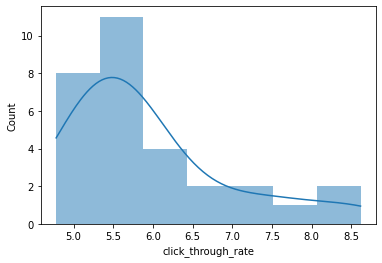

In [111]:
sns.histplot(q1_ctr_best['click_through_rate'], kde=True, linewidth=0)
q1_ctr_best.head(2)

,video_id,title,date,comment_count,share_count,dislike_count,like_count,subscribers_lost,subscribers_gained,rpm,cpm,average_view_ratio,average_watch_time,view_count,total_watch_time,net_subscribers,estimated_revenue,impression_count,click_through_rate
167,9D7GzskcyUk,5 Tips for Crushing the Work From Home Life,2020-04-20,18,32,14,200,2,50,9.476562,17.421875,34.968750,119,4934,164.5000,48,46.75,580788,0.509766
70,UcilY6HDuL8,10000 Subscriber and 100th Video Special (Data...,2020-05-13,58,12,4,149,2,53,0.000000,NaN,24.015625,41,3064,35.0625,51,0.00,400077,0.489990


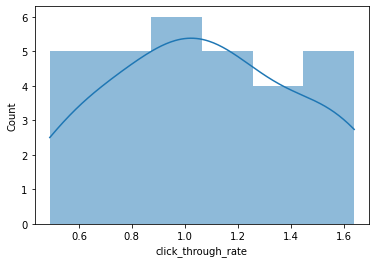

In [112]:
sns.histplot(q1_ctr_worst['click_through_rate'], kde=True, linewidth=0)
q1_ctr_worst.tail(2)

In [137]:
def parse_q1(df):
    q1_video_id = df["video_id"].values
    q1_titles = df["title"].values
    q1_thumbnails = []
    for i in range(len(q1_video_id)):
        thumbnail = data1_agg_country_suscriber[data1_agg_country_suscriber["video_id"] == q1_video_id[i]].iloc[0]["thumbnail"]
        q1_thumbnails.append(thumbnail)
    q1_thumbnails = np.array(q1_thumbnails)

    return q1_video_id, q1_titles, q1_thumbnails

def request_url_image(url):
    # Adding information about user agent
    opener=urllib.request.build_opener()
    opener.addheaders=[('User-Agent','Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1941.0 Safari/537.36')]
    urllib.request.install_opener(opener)    
    # calling urlretrieve function to get resource
    img = Image.open(BytesIO(urllib.request.urlopen(url).read()))

    return img

In [138]:
# retrieve images
q1_video_id_b, q1_titles_b, q1_thumbnails_b = parse_q1(q1_ctr_best)
q1_thumbnails_as_img_b = []
for i in tqdm(range(len(q1_thumbnails_b))):
    q1_thumbnails_as_img_b.append(request_url_image(q1_thumbnails_b[i]))

KeyboardInterrupt: 

In [129]:
q1_video_id_w, q1_titles_w, q1_thumbnails_w = parse_q1(q1_ctr_worst)
q1_thumbnails_as_img_w = []
for i in tqdm(range(len(q1_thumbnails_w))):
    print(q1_thumbnails_w[i])
    q1_thumbnails_as_img_w.append(request_url_image(q1_thumbnails_w[i]))

https://i.ytimg.com/vi/OtqQYqRNDGI/hqdefault.jpg
https://i.ytimg.com/vi/3BEtGaz70rQ/hqdefault.jpg
https://i.ytimg.com/vi/scSc6YSanQ0/hqdefault.jpg
https://i.ytimg.com/vi/BlSrorP32WM/hqdefault.jpg
https://i.ytimg.com/vi/9ZwVqXUHf6o/hqdefault.jpg
https://i.ytimg.com/vi/a-Syoa9mPhM/hqdefault.jpg
https://i.ytimg.com/vi/Fs_LG5Y8GIU/hqdefault.jpg
https://i.ytimg.com/vi/742LQ38OioU/hqdefault.jpg
https://i.ytimg.com/vi/n6MiRgxN5iA/hqdefault.jpg
https://i.ytimg.com/vi/lUUqrRgerd8/hqdefault.jpg
https://i.ytimg.com/vi/4qZINLzwYyk/hqdefault.jpg
https://i.ytimg.com/vi/uic34RTaI-w/hqdefault.jpg
https://i.ytimg.com/vi/n3vw0M5RrPU/hqdefault.jpg
https://i.ytimg.com/vi/_K6cNdgN3CI/hqdefault.jpg
https://i.ytimg.com/vi/ELFGsNqZrlM/hqdefault.jpg
https://i.ytimg.com/vi/fU3DOXjwufg/hqdefault.jpg
https://i.ytimg.com/vi/smeFkHwnM_k/hqdefault.jpg
https://i.ytimg.com/vi/-3d1NctSv0c/hqdefault.jpg



KeyboardInterrupt: 

In [119]:
def plot_imgs_grid(rows,cols,titles,images,figsize=(32,24)):

    f, axarr = plt.subplots(5,6, figsize=(32,24)) # (width,height)

    for i in range(rows):
        for j in range(cols):
            title = "\n".join(wrap(titles[i+j], width=30))
            axarr[i,j].imshow(images[i+j])
            axarr[i,j].set_title(title,fontsize=20)

In [ ]:
plot_imgs_grid(5,6,q1_titles_b,q1_thumbnails_as_img_b)

In [ ]:
plot_imgs_grid(5,6,q1_titles_w,q1_thumbnails_as_img_w)

In [121]:
def get_frequency(titles):
    m = dict()
    for title in titles:
        words = title.split(" ")
        for word in words:
            if word not in m:
                m[word] = 0
            m[word] += 1

    return m
        

In [123]:
print({k: v for k, v in sorted(get_frequency(q1_titles_b).items(), key=lambda item: item[1])})

{'Quit': 1, 'Get': 1, 'Masters': 1, 'Twitter': 1, 'with': 1, 'Twitterscraper': 1, 'Learn': 1, 'R': 1, 'Best': 1, 'Computer': 1, 'Beginners': 1, 'Does': 1, 'Actually': 1, 'Do?': 1, '2': 1, 'Collection)': 1, '7': 1, '(Documenting': 1, 'Work)': 1, 'YOU': 1, 'Can': 1, 'Land': 1, 'Collision': 1, 'Course:': 1, 'Betting': 1, '+': 1, 'Is': 1, 'Right': 1, 'For': 1, 'You?': 1, 'Math': 1, 'Needed': 1, 'Mastering': 1, 'Reviewing': 1, 'Resumes': 1, 'Episode': 1, '12': 1, '(3': 1, 'Different': 1, 'Resumes!)': 1, 'Became': 1, 'Business': 1, 'Background': 1, 'Fundamentals:': 1, 'Exploration': 1, '(Pandas)': 1, 'Predicting': 1, 'Crypto-Currency': 1, 'Price': 1, 'RNN': 1, 'lSTM': 1, '&': 1, 'GRU': 1, 'Work': 1, 'Home': 1, 'Scientist:': 1, 'Day': 1, 'Life': 1, 'nba_api': 1, '5': 1, 'Essential': 1, 'Portfolio': 1, 'Simulate': 1, 'Games': 1, 'Reasons': 1, 'NOT': 1, '1': 1, '(Project': 1, 'Planning)': 1, 'is': 1, 'Really?': 1, 'that': 1, 'Got': 1, 'Me': 1, 'Golf': 1, 'STATS:': 1, 'Strokes': 1, 'Gained': 1, 

In [124]:
print({k: v for k, v in sorted(get_frequency(q1_titles_w).items(), key=lambda item: item[1])})

{'🌶': 1, 'Hot': 1, 'Topics': 1, 'Tech:': 1, '#SHORTS': 1, 'Far': 1, 'NBA': 1, '3-Point': 1, 'Line': 1, 'Actually': 1, 'Be?': 1, 'Statistics': 1, 'Saved': 1, 'US': 1, 'SERIOUS': 1, '$$$$': 1, 'During': 1, 'WW2': 1, '#Shorts': 1, '2': 1, 'Offices': 1, 'When': 1, 'Goes': 1, 'Wrong': 1, 'Take': 1, 'Good': 1, 'Great': 1, 'Can': 1, 'Learn': 1, 'Without': 1, 'Computer?': 1, 'Productivity,': 1, 'Motivation,': 1, 'Organization': 1, '(ft.': 1, 'Codebasics)': 1, 'EVERYONE': 1, 'Start': 1, 'Podcast': 1, '(Including': 1, 'YOU)': 1, "It's": 1, 'Like': 1, 'be': 1, 'Socially': 1, 'Distanced': 1, 'Scientist': 1, '(A': 1, 'Day': 1, 'Life)': 1, 'State': 1, 'Krish': 1, 'Naik': 1, '[Panel': 1, 'Discussion]': 1, 'Balance': 1, '(7': 1, 'Secrets)': 1, 'Learned': 1, '4': 1, '(Resume': 1, 'Github)': 1, 'Is': 1, 'it': 1, 'Important': 1, 'Share': 1, 'Work?': 1, '(Ft.': 1, 'Eric': 1, 'Weber)': 1, 'is': 1, 'Future': 1, 'my': 1, 'Comment': 1, 'Leaderboard': 1, 'Project?': 1, 'Welcome': 1, 'To': 1, 'My': 1, 'Q': 1, '

### Conclusion

- 

## Q2: What type of content are people engaging with the most or watching the longest? (avg watch time and avg view percentage)

### Analysis

### Conclusion

## Q3: What is the SEO applied and what it's the performance?

### Analysis

### Conclusion

## Q4: Who is the core audience and what are they interested in?

### Analysis

### Conclusion

## Q5: What types of videos have lead to the most growth and bad growth (subs removed)? 

### Analysis

### Conclusion

## Q6: When the retention peaks happen? what did the youtuber for that peaks? (Important question for SEO-Frame techniques)

### Analysis

### Conclusion

## Q7: What are the keywords used? These answer to search intents?

### Analysis

### Conclusion

## Q8: What are the SEO techniques applied? Which give the best results?

### Analysis

### Conclusion

## Q9: What are the top positive/negative words/sentences in comments?

### Analysis

### Conclusion

## Q10: What videos produces more relative likes?

### Analysis

### Conclusion

## Q11: What videos produces more relative dislikes?

### Analysis

### Conclusion

## Q12: What videos produces more relative comments added?

### Analysis

### Conclusion

## Q13: What videos generates more social value? (shares)

### Analysis

### Conclusion

## Q14: What are the topics of the most liked comments? (clusters)

### Analysis

### Conclusion

<a id="5"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">MODELING</p>

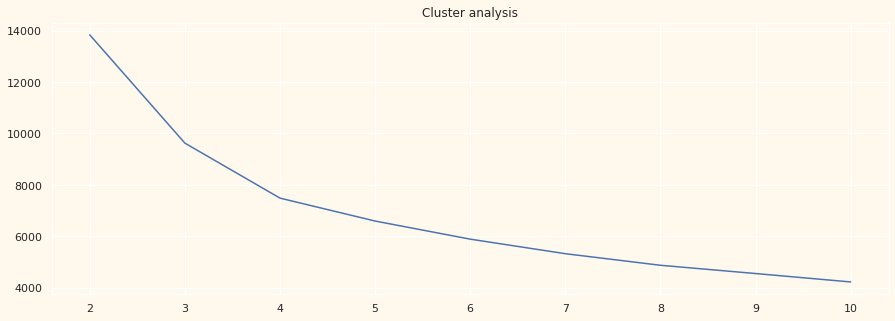

In [74]:
distorsions = []

grid_clusters = [i for i in range(2,11)]
for k in grid_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(grid_clusters, distorsions)
plt.grid(True)
plt.title('Cluster analysis')
plt.show()


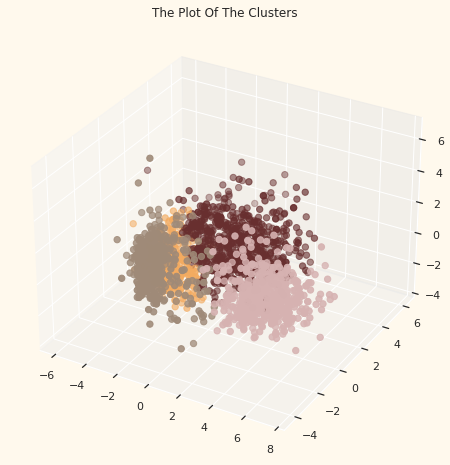

In [75]:
x =X_train["col1"]
y =X_train["col2"]
z =X_train["col3"]
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(X_train)
X_clean["Clusters"] = yhat_AC

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=X_clean["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

<a id="6"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATION</p>

<a id="7"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DISCUSSION</p>

## Patterns study

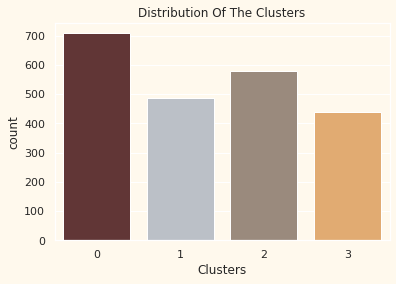

In [76]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=X_clean["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

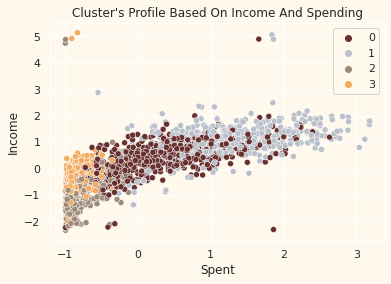

In [77]:
pl = sns.scatterplot(data = X_clean,x=X_clean["Spent"], y=X_clean["Income"],hue=X_clean["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

## Profiling

## Conclusions
- 

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DEPLOYMENT AND ENSEMBLES</p>

<a id="9"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>

[Return to table of contents](#top)